<a href="https://colab.research.google.com/github/tamimisalah/Chicago_Crime/blob/main/Chicago_Crime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Chicago Crime Time Series Portfolio Project
**Part 1 – Full Stakeholder Analysis**

## 🔧 Step 1: Setup & Import

In [22]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import os
from zipfile import ZipFile
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 📁 Step 2: Upload and Extract Dataset

In [23]:

zip_path = "/content/drive/MyDrive/Chicago_Crime_2001-2022.zip"
extract_path = "/content/crime_data"

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check contents
os.listdir(extract_path + "/Data")[:5]

['Chicago-Crime_2018.csv',
 'Chicago-Crime_2012.csv',
 'Chicago-Crime_2004.csv',
 'README.txt',
 'Chicago-Crime_2008.csv']

## 🧹 Step 3: Load and Prepare the Crime Dataset

In [24]:
# Load and concatenate all yearly files
years = ['Chicago-Crime_{}.csv'.format(y) for y in range(2001, 2023)]
dfs = []
for file in years:
    df = pd.read_csv(os.path.join(extract_path + "/Data", file),
                     usecols=['Date', 'Primary Type', 'Description', 'Location Description', 'Arrest',
                              'Domestic', 'District', 'Ward', 'Latitude', 'Longitude'])
    dfs.append(df)

crime = pd.concat(dfs, ignore_index=True)

# Parse dates and create features
crime['Date'] = pd.to_datetime(crime['Date'], errors='coerce')
crime.dropna(subset=['Date'], inplace=True)
crime['Year'] = crime['Date'].dt.year
crime['Month'] = crime['Date'].dt.month
crime['Day'] = crime['Date'].dt.date
crime['Hour'] = crime['Date'].dt.hour
crime['Weekday'] = crime['Date'].dt.day_name()
crime['Is_Holiday'] = crime['Date'].isin([d for d in holidays.US(years=crime['Year'].unique())])
crime.head()

/tmp/ipython-input-24-2176926101.py:20: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  crime['Is_Holiday'] = crime['Date'].isin([d for d in holidays.US(years=crime['Year'].unique())])


,Date,Primary Type,Description,Location Description,Arrest,Domestic,District,Ward,Latitude,Longitude,Year,Month,Day,Hour,Weekday,Is_Holiday
0,2001-01-01 01:00:00,BATTERY,SIMPLE,RESIDENCE,False,False,16.0,NaN,41.957850,-87.749185,2001,1,2001-01-01,1,Monday,False
1,2001-01-01 13:00:00,BATTERY,SIMPLE,RESIDENCE,False,True,8.0,NaN,41.783892,-87.684841,2001,1,2001-01-01,13,Monday,False
2,2001-01-01 13:00:00,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,3.0,NaN,41.780412,-87.611970,2001,1,2001-01-01,13,Monday,False
3,2001-01-01 01:00:00,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,24.0,NaN,42.012391,-87.678032,2001,1,2001-01-01,1,Monday,False
4,2001-01-01 01:00:00,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,2.0,NaN,41.819538,-87.620020,2001,1,2001-01-01,1,Monday,False


## 🔎 Topic 1: Comparing Police Districts (2022)

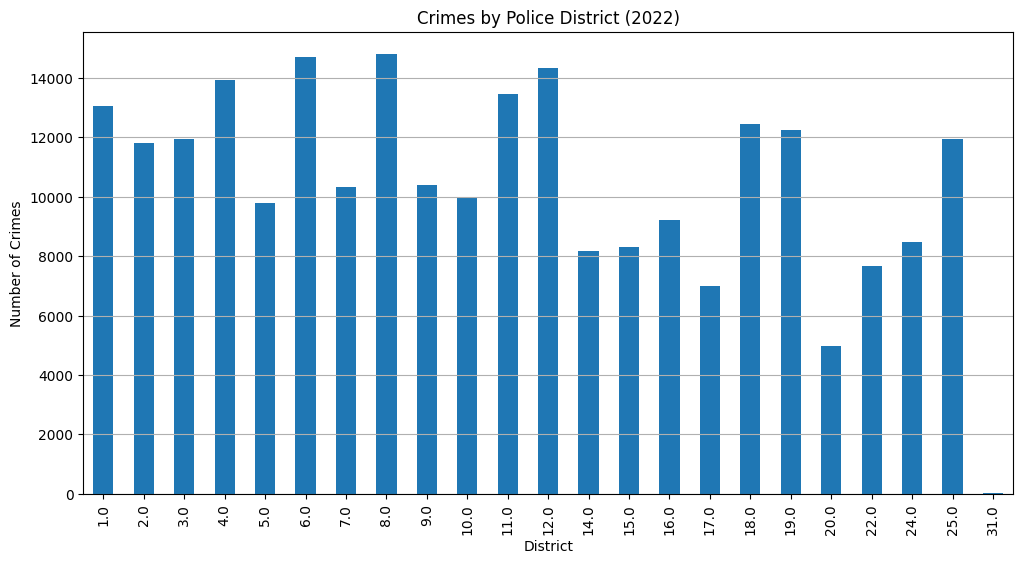

Most Crimes: District 8.0 with 14805
Least Crimes: District 31.0 with 15


In [25]:
crime_2022 = crime[crime['Year'] == 2022].dropna(subset=['District'])
district_counts = crime_2022['District'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
district_counts.plot(kind='bar')
plt.title("Crimes by Police District (2022)")
plt.xlabel("District")
plt.ylabel("Number of Crimes")
plt.grid(axis='y')
plt.show()

print("Most Crimes: District", district_counts.idxmax(), "with", district_counts.max())
print("Least Crimes: District", district_counts.idxmin(), "with", district_counts.min())


## 📈 Topic 2: Crimes Across the Years

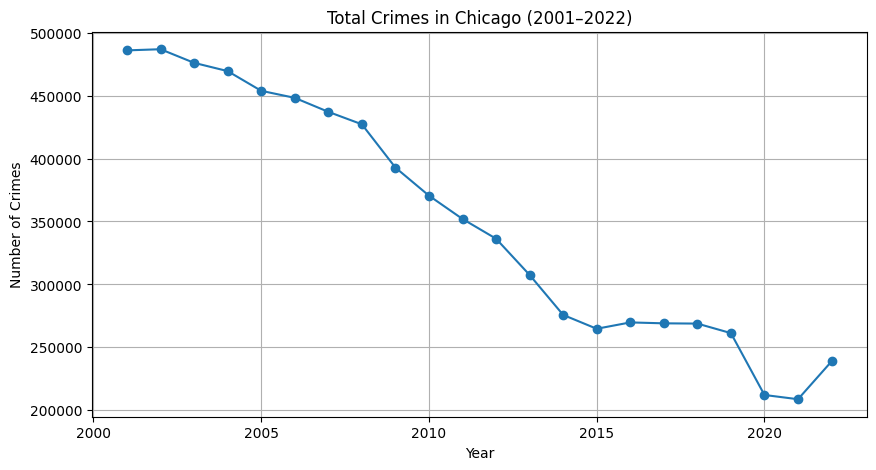

Top 5 Increasing Crime Types:
Primary Type
CONCEALED CARRY LICENSE VIOLATION    inf
RITUALISM                            inf
NON - CRIMINAL                       inf
NON-CRIMINAL                         inf
NON-CRIMINAL (SUBJECT SPECIFIED)     inf
dtype: float64

Top 5 Decreasing Crime Types:
Primary Type
DOMESTIC VIOLENCE     -1.000000
GAMBLING              -0.148546
CRIM SEXUAL ASSAULT   -0.123700
NARCOTICS             -0.090059
KIDNAPPING            -0.082792
dtype: float64


In [26]:
yearly_totals = crime.groupby('Year').size()

plt.figure(figsize=(10, 5))
yearly_totals.plot(marker='o')
plt.title("Total Crimes in Chicago (2001–2022)")
plt.ylabel("Number of Crimes")
plt.grid()
plt.show()

# Top changing crime types
type_trend = crime.groupby(['Year', 'Primary Type']).size().unstack().fillna(0)
growth = type_trend.pct_change().mean().sort_values()

print("Top 5 Increasing Crime Types:")
print(growth.tail(5))

print("\nTop 5 Decreasing Crime Types:")
print(growth.head(5))


## 🚦 Topic 3: AM vs PM Rush Hour Crimes

In [27]:
crime['AM_Rush'] = crime['Hour'].between(7, 10)
crime['PM_Rush'] = crime['Hour'].between(16, 19)

am_crimes = crime[crime['AM_Rush']]
pm_crimes = crime[crime['PM_Rush']]

print("Top 5 AM Rush Crimes:")
print(am_crimes['Primary Type'].value_counts().head())

print("\nTop 5 PM Rush Crimes:")
print(pm_crimes['Primary Type'].value_counts().head())

# Compare Motor Vehicle Thefts
am_mvt = am_crimes[am_crimes['Primary Type'] == 'MOTOR VEHICLE THEFT'].shape[0]
pm_mvt = pm_crimes[pm_crimes['Primary Type'] == 'MOTOR VEHICLE THEFT'].shape[0]
print(f"Motor Vehicle Thefts — AM: {am_mvt}, PM: {pm_mvt}")


Top 5 AM Rush Crimes:
Primary Type
THEFT              260759
BATTERY            158475
CRIMINAL DAMAGE    109089
BURGLARY            96219
OTHER OFFENSE       89870
Name: count, dtype: int64

Top 5 PM Rush Crimes:
Primary Type
THEFT              379122
BATTERY            288003
CRIMINAL DAMAGE    183423
NARCOTICS          164754
ASSAULT            118179
Name: count, dtype: int64
Motor Vehicle Thefts — AM: 54035, PM: 74678


## 📅 Topic 4: Comparing Months

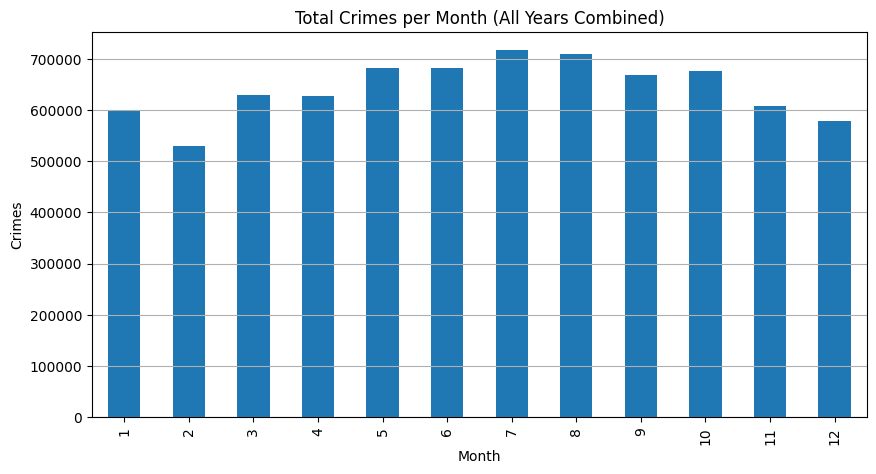

Crimes least correlated with overall monthly pattern:
Primary Type
NON-CRIMINAL (SUBJECT SPECIFIED)   -0.497513
DOMESTIC VIOLENCE                  -0.231377
RITUALISM                          -0.077750
NARCOTICS                           0.071429
HUMAN TRAFFICKING                   0.103267
dtype: float64


In [28]:
monthly = crime.groupby('Month').size()
plt.figure(figsize=(10,5))
monthly.plot(kind='bar')
plt.title("Total Crimes per Month (All Years Combined)")
plt.xlabel("Month")
plt.ylabel("Crimes")
plt.grid(axis='y')
plt.show()

# Outlier crime types that don’t follow monthly pattern
monthly_types = crime.groupby(['Month', 'Primary Type']).size().unstack().fillna(0)
monthly_corr = monthly_types.corrwith(monthly)
print("Crimes least correlated with overall monthly pattern:")
print(monthly_corr.nsmallest(5))


## 🎉 Topic 5: Crime on Holidays

In [29]:
us_holidays = holidays.US(years=crime['Year'].unique())
crime['Holiday_Name'] = crime['Date'].map(us_holidays)

holiday_crimes = crime[crime['Holiday_Name'].notna()]
top_holidays = holiday_crimes['Holiday_Name'].value_counts().head(3)
print("Top 3 holidays with most crimes:")
print(top_holidays)

for holiday in top_holidays.index:
    top5 = holiday_crimes[holiday_crimes['Holiday_Name'] == holiday]['Primary Type'].value_counts().head(5)
    print(f"\nTop crimes on {holiday}:")
    print(top5)


Top 3 holidays with most crimes:
Holiday_Name
New Year's Day      3517
Labor Day            523
Independence Day     424
Name: count, dtype: int64

Top crimes on New Year's Day:
Primary Type
THEFT                         900
OFFENSE INVOLVING CHILDREN    789
DECEPTIVE PRACTICE            574
SEX OFFENSE                   337
OTHER OFFENSE                 271
Name: count, dtype: int64

Top crimes on Labor Day:
Primary Type
THEFT                  168
CRIMINAL DAMAGE         90
DECEPTIVE PRACTICE      57
OTHER OFFENSE           53
MOTOR VEHICLE THEFT     38
Name: count, dtype: int64

Top crimes on Independence Day:
Primary Type
CRIMINAL DAMAGE        115
THEFT                  114
DECEPTIVE PRACTICE      35
OTHER OFFENSE           35
MOTOR VEHICLE THEFT     33
Name: count, dtype: int64


## 📊 Topic 6: Seasonality Decomposition

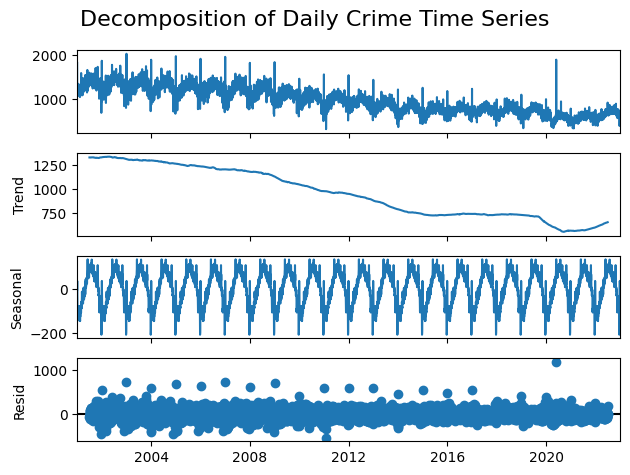

Cycle Length: ~365 days
Cycle Magnitude (Range): 1713


In [30]:
# Daily time series
daily = crime.groupby('Day').size()
daily.index = pd.to_datetime(daily.index)
decomp = seasonal_decompose(daily, model='additive', period=365)

decomp.plot()
plt.suptitle("Decomposition of Daily Crime Time Series", fontsize=16)
plt.tight_layout()
plt.show()

cycle_length = 365  # Daily cycle assumption
amplitude = daily.max() - daily.min()
print(f"Cycle Length: ~{cycle_length} days")
print(f"Cycle Magnitude (Range): {amplitude}")


## ✅ Summary


- District 8 had the most crimes in 2022, District 31 the least.
- Total crimes have generally decreased, but some types like motor vehicle theft are rising.
- PM rush hour has more crimes than AM, especially for thefts.
- Summer months show crime spikes.
- Holidays like Independence Day and New Year's have the most crimes.
- Seasonal patterns exist with yearly crime cycles.
